In [1]:
#Note: Data cleanup and EDA already done as part of logistic_regression_trainer.ipynb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn


In [2]:
df =  pd.read_csv('../../dataset/booking_train.csv')
df.columns = df.columns.str.lower().str.replace(' ', '_')
df['type_of_meal']=df['type_of_meal'].str.lower().str.replace(' ', '_')
df['room_type']=df['room_type'].str.lower().str.replace(' ', '_')
df['market_segment_type']=df['market_segment_type'].str.lower().str.replace(' ', '_')
df = df[~df["date_of_reservation"].str.contains("-")]
df['month_of_reservation'] = pd.to_datetime(df['date_of_reservation'],format='%m/%d/%Y').dt.strftime('%b') 
df['booking_status'] = (df.booking_status == 'Canceled').astype(int)



In [3]:
#Perform the train/validation/test split with Scikit-Learn
from sklearn.model_selection import train_test_split

df_full_train, df_test = train_test_split(df,test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train,test_size=0.25, random_state=1)
df_full_train  = df_full_train.reset_index(drop=True)
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
y_full_train = df_full_train['booking_status'].values
y_train = df_train['booking_status'].values
y_val = df_val['booking_status'].values
y_test = df_test['booking_status'].values
del df_train['booking_status']
del df_val['booking_status']
del df_test['booking_status']


In [4]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [5]:
numerical = ['number_of_adults','number_of_children','number_of_weekend_nights','number_of_week_nights','lead_time','p-c','p-not-c','average_price','special_requests']
categorical = ['type_of_meal','room_type','market_segment_type','car_parking_space','repeated','month_of_reservation']


train_dict = df_train[categorical + numerical].to_dict(orient='records')
val_dict = df_val[categorical + numerical].to_dict(orient='records')
test_dict = df_test[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dict)
X_val = dv.transform(val_dict)
X_test = dv.transform(test_dict)
features = dv.get_feature_names_out()
features

array(['average_price', 'car_parking_space', 'lead_time',
       'market_segment_type=aviation',
       'market_segment_type=complementary',
       'market_segment_type=corporate', 'market_segment_type=offline',
       'market_segment_type=online', 'month_of_reservation=Apr',
       'month_of_reservation=Aug', 'month_of_reservation=Dec',
       'month_of_reservation=Feb', 'month_of_reservation=Jan',
       'month_of_reservation=Jul', 'month_of_reservation=Jun',
       'month_of_reservation=Mar', 'month_of_reservation=May',
       'month_of_reservation=Nov', 'month_of_reservation=Oct',
       'month_of_reservation=Sep', 'number_of_adults',
       'number_of_children', 'number_of_week_nights',
       'number_of_weekend_nights', 'p-c', 'p-not-c', 'repeated',
       'room_type=room_type_1', 'room_type=room_type_2',
       'room_type=room_type_3', 'room_type=room_type_4',
       'room_type=room_type_5', 'room_type=room_type_6',
       'room_type=room_type_7', 'special_requests',
       'typ

In [6]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

DecisionTreeClassifier()

In [7]:
y_pred = dt.predict_proba(X_train)[:, 1]
roc_auc_score(y_train, y_pred)


0.999888804055025

In [8]:
y_pred = dt.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.8505883852311544

In [9]:
#overffitning?
#train dataset - 99% val dataset -  85%
#class sklearn.tree.DecisionTreeClassifier(*, criterion='gini', splitter='best', 
#max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None,
#random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, class_weight=None, ccp_alpha=0.0)[source]


In [10]:
#Lets tune maxdepth, min_samples_leaf, min_sample_split

dt = DecisionTreeClassifier(max_depth=5)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5)

In [11]:
y_train_pred = dt.predict_proba(X_train)[:, 1]
y_val_pred = dt.predict_proba(X_val)[:, 1]
roc_auc_score(y_train, y_train_pred), roc_auc_score(y_val, y_val_pred)


(0.887014161008274, 0.8757308656607078)

In [12]:
for depth in [4, 5, 6, 8, 10, 12, 15, 20, None]:
    dt = DecisionTreeClassifier(max_depth=depth)
    dt.fit(X_train, y_train)
    y_train_pred = dt.predict_proba(X_train)[:, 1]
    y_val_pred = dt.predict_proba(X_val)[:, 1]
    train_auc= roc_auc_score(y_train, y_train_pred)
    val_auc = roc_auc_score(y_val, y_val_pred)

    print('%4s -> trian_auc -> %.3f -> val_auc-> %.3f' % (depth, train_auc, val_auc))

   4 -> trian_auc -> 0.868 -> val_auc-> 0.865
   5 -> trian_auc -> 0.887 -> val_auc-> 0.876
   6 -> trian_auc -> 0.901 -> val_auc-> 0.891
   8 -> trian_auc -> 0.925 -> val_auc-> 0.911
  10 -> trian_auc -> 0.945 -> val_auc-> 0.926
  12 -> trian_auc -> 0.960 -> val_auc-> 0.924
  15 -> trian_auc -> 0.976 -> val_auc-> 0.912
  20 -> trian_auc -> 0.993 -> val_auc-> 0.883
None -> trian_auc -> 1.000 -> val_auc-> 0.852


In [13]:
#max_depth 10 looks higher and not a overfit.
#min samples leaf

for m in [1, 5, 10, 15, 20, 50, 100, 200]:
    dt = DecisionTreeClassifier(max_depth=10, min_samples_leaf=m)
    dt.fit(X_train, y_train)
    y_train_pred = dt.predict_proba(X_train)[:, 1]
    y_val_pred = dt.predict_proba(X_val)[:, 1]
    train_auc= roc_auc_score(y_train, y_train_pred)
    val_auc = roc_auc_score(y_val, y_val_pred)

    print('%s -> trian_auc -> %.3f -> val_auc-> %.3f' % (m, train_auc, val_auc))

1 -> trian_auc -> 0.945 -> val_auc-> 0.926
5 -> trian_auc -> 0.943 -> val_auc-> 0.926
10 -> trian_auc -> 0.941 -> val_auc-> 0.927
15 -> trian_auc -> 0.938 -> val_auc-> 0.926
20 -> trian_auc -> 0.936 -> val_auc-> 0.925
50 -> trian_auc -> 0.923 -> val_auc-> 0.910
100 -> trian_auc -> 0.910 -> val_auc-> 0.902
200 -> trian_auc -> 0.899 -> val_auc-> 0.888


In [14]:
#min samples leaf 10 seems better

dt = DecisionTreeClassifier(max_depth=10, min_samples_leaf=10)
dt.fit(X_train, y_train)
y_val_pred = dt.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_val_pred)
auc

0.9263006733524757

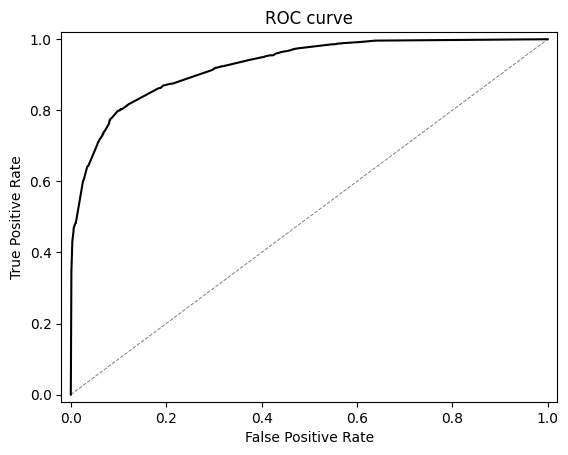

In [15]:
fpr,tpr,_ = roc_curve(y_val, y_val_pred)
plt.plot(fpr, tpr, color='black')
plt.plot([0, 1], [0, 1], color='black', lw=0.7, linestyle='dashed', alpha=0.5)

plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('ROC curve')

plt.show()

In [16]:
from sklearn.tree import export_text
r=export_text(dt, feature_names=list(features))
#print(r)

In [17]:
def train(df, y):
    data = df[categorical + numerical].to_dict(orient='records')
    dv = DictVectorizer(sparse=False)
    dv.fit(data)
    X = dv.transform(data)
    model = DecisionTreeClassifier(max_depth=10, min_samples_leaf=10)
    model.fit(X_train, y_train)
    return dv, model


def predict(df, dv, model):
    data = df[categorical + numerical].to_dict(orient='records')
    
    X = dv.transform(data)

    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [18]:
dv, model = train(df_full_train, y_full_train)
y_test_pred = predict(df_test, dv, model)
auc = roc_auc_score(y_test, y_test_pred)
auc

0.9226355085565802

In [20]:
import pickle
with open('../../model/cancellation-pred-model-decision-tree.bin', 'wb') as f_out:
    pickle.dump((dv,model),f_out)

In [ ]:
#auc - 0.9224780679280424